## in this file we will be developing the class for mlmodels

- set a model
- train a model
- evaluate a model
- predict
- load the data ( from datasplitter class )
- option : last minute processing ( scaling or encoding )
- save the model
- load model : load a pretrained from a file
- get metrics
- confusion matrix
- feature importance ( if this is supported by the model )
- Learning curve : plot training and validation performance over epochs ( if applicable )
- ROC/AUC curve
- precision recall curve
-

In [152]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    log_loss,
    matthews_corrcoef,
    balanced_accuracy_score,
    cohen_kappa_score,
    hamming_loss,
)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

In [153]:
class MLModel:
    def __init__(self):
        """
        Initialize the MLmodel class."""
        self.model = None
    def set_model(self, model):
        """set a machine learning model"""
        if model is None:
            raise ValueError("The model cannot be None. Please provide a valid machine learning model.")

        self.model = model
        print(f"Model set successfully: {model.__class__.__name__}")

    def train(self, X_train, y_train):
        """
        Train the machine learning model on the provided training data.
            X_train (pd.DataFrame or np.ndarray): Feature matrix for training.
            y_train (pd.Series or np.ndarray): Target vector for training.
        """
        if self.model is None:
            raise ValueError("No model is set. Use `set_model` to specify a model before training.")

        try:
            # Train the model
            self.model.fit(X_train, y_train)
            print("Model trained successfully.")
        except Exception as e:
            print(f"An error occurred during training: {e}")

    def evaluate(self, X_test, y_test, metrics=['accuracy']):
        """
        Evaluate the model's performance on the test dataset.
        Args:
            X_test (pd.DataFrame or np.ndarray): Feature matrix for testing.
            y_test (pd.Series or np.ndarray): Target vector for testing.
            metrics (list): List of metrics to compute. Supported values:
                            'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'confusion_matrix'.
        """
        if self.model is None:
            raise ValueError("No model is set. Use `set_model` to specify a model before evaluation.")

        if not hasattr(self.model, 'predict'):
            raise ValueError("The model does not support prediction. Ensure the model is trained and supports the `predict` method.")

        try:
            # Get predictions
            y_pred = self.model.predict(X_test)

            # If the model outputs probabilities, convert them to binary predictions for metrics
            if hasattr(self.model, "predict_proba") and 'roc_auc' in metrics:
                y_pred_proba = self.model.predict_proba(X_test)[:, 1]
            else:
                y_pred_proba = None

            # Compute metrics
            results = {}
            if 'accuracy' in metrics:
                results['accuracy'] = accuracy_score(y_test, y_pred)
            if 'precision' in metrics:
                results['precision'] = precision_score(y_test, y_pred, average='weighted')
            if 'recall' in metrics:
                results['recall'] = recall_score(y_test, y_pred, average='weighted')
            if 'f1' in metrics:
                results['f1'] = f1_score(y_test, y_pred, average='weighted')
            if 'roc_auc' in metrics and y_pred_proba is not None:
                results['roc_auc'] = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
            if 'confusion_matrix' in metrics:
                results['confusion_matrix'] = confusion_matrix(y_test, y_pred)

            # Print results
            print("Evaluation Results:")
            for metric, value in results.items():
                print(f"{metric}: {value}")

            return results

        except Exception as e:
            print(f"An error occurred during evaluation: {e}")

    def predict(self, X, proba=False):
        """
        Generate predictions for the given feature matrix.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix for prediction.
            proba (bool): If True, returns probabilities. Otherwise, returns class labels.

        Returns:
            np.ndarray: Predictions (class labels) or probabilities.
        """
        if self.model is None:
            raise ValueError("No model is set. Use `set_model` to specify a model before prediction.")

        if not hasattr(self.model, 'predict'):
            raise ValueError("The model does not support prediction. Ensure the model is trained and supports the `predict` method.")

        if proba:
            # Check if the model supports probability predictions
            if hasattr(self.model, "predict_proba"):
                probabilities = self.model.predict_proba(X)

                # For binary classification, return the probabilities for the positive class
                if probabilities.shape[1] == 2:
                    return probabilities[:, 1]

                # For multi-class classification, return all probabilities
                return probabilities
            else:
                raise ValueError("The model does not support probability predictions.")
        else:
            # Generate class label predictions
            return self.model.predict(X)




    def get_metrics(self, y_true, y_pred, y_proba=None):
        """
        Compute accuracy, precision, recall, F1 score, and ROC-AUC (if probabilities are provided).

        Args:
            y_true (np.ndarray or pd.Series): Ground truth target values.
            y_pred (np.ndarray or pd.Series): Predicted target values (class labels).
            y_proba (np.ndarray, optional): Predicted probabilities (required for ROC-AUC).

        Returns:
            dict: A dictionary containing accuracy, precision, recall, F1 score, and ROC-AUC (if applicable).
        """
        # Compute core metrics
        results = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="weighted"),
            "recall": recall_score(y_true, y_pred, average="weighted"),
            "f1": f1_score(y_true, y_pred, average="weighted"),
        }

        # Add ROC-AUC if probabilities are provided and it's binary classification
        if y_proba is not None and len(set(y_true)) == 2:
            results["roc_auc"] = roc_auc_score(y_true, y_proba)

        # Print the metrics
        print("Computed Metrics:")
        for metric, value in results.items():
            print(f"{metric}: {value:.4f}")

        return results



    def plot_confusion_matrix(self, y_true, y_pred, labels=None, normalize=False, cmap="Blues"):
        """
        Plot a confusion matrix and return the figure.

        Args:
            y_true (np.ndarray or pd.Series): Ground truth target values.
            y_pred (np.ndarray or pd.Series): Predicted target values (class labels).
            labels (list, optional): List of class labels to display on the axes. If None, uses unique values from `y_true`.
            normalize (bool): If True, normalize the confusion matrix by row.
            cmap (str): Colormap for the heatmap.

        Returns:
            matplotlib.figure.Figure: The generated confusion matrix figure.
        """
        # If labels are not provided, use the unique values from y_true
        if labels is None:
            labels = sorted(set(y_true))

        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true" if normalize else None)

        # Create the heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))

        # Return the figure
        return fig


    def plot_roc_auc(self, y_true, y_proba, labels=None, average="macro"):
        """
        Plot the ROC curve and calculate the AUC for binary or multi-class classification.
        Args:
            y_true (np.ndarray or pd.Series): Ground truth target values.
            y_proba (np.ndarray): Predicted probabilities.
            labels (list, optional): List of class labels. If None, inferred from `y_true`.
            average (str): Averaging method for multi-class AUC ('macro', 'weighted').

        """
        # Handle binary classification
        if len(set(y_true)) == 2:
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            auc = roc_auc_score(y_true, y_proba)

            # Plot ROC curve
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
            ax.plot([0, 1], [0, 1], "k--", label="Random guess")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("ROC Curve")
            ax.legend(loc="lower right")
            plt.grid()

            return fig

        # Handle multi-class classification
        else:
            if labels is None:
                labels = sorted(set(y_true))

            # Binarize the labels
            y_true_binarized = label_binarize(y_true, classes=labels)

            # Compute ROC curve and AUC for each class
            fig, ax = plt.subplots(figsize=(8, 6))
            for i, label in enumerate(labels):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_proba[:, i])
                auc = roc_auc_score(y_true_binarized[:, i], y_proba[:, i])
                ax.plot(fpr, tpr, label=f"Class {label} (AUC = {auc:.2f})")

            # Calculate macro-average AUC
            macro_auc = roc_auc_score(y_true_binarized, y_proba, average=average)
            ax.plot([0, 1], [0, 1], "k--", label=f"Macro-average (AUC = {macro_auc:.2f})")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Multi-Class ROC Curve")
            ax.legend(loc="lower right")
            plt.grid()

            return fig


    def plot_precision_recall_curve(self, y_true, y_proba, positive_label=1):
        """
        Plot the Precision-Recall curve and calculate the Average Precision (AP) score.

        Args:
            y_true (np.ndarray or pd.Series): Ground truth binary target values.
            y_proba (np.ndarray): Predicted probabilities for the positive class.
            positive_label (int): The label of the positive class (default: 1).

        Returns:
            matplotlib.figure.Figure: The generated Precision-Recall curve figure.
        """
        # Compute precision and recall
        precision, recall, thresholds = precision_recall_curve(y_true, y_proba, pos_label=positive_label)

        # Calculate Average Precision (AP) score
        ap_score = average_precision_score(y_true, y_proba)

        # Plot the Precision-Recall curve
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(recall, precision, label=f"AP = {ap_score:.2f}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curve")
        ax.legend(loc="best")
        plt.grid()

In [154]:

# Load dataset and split
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the MLmodel class
ml_model = MLModel()

# Set the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
ml_model.set_model(xgb_model)

Model set successfully: XGBClassifier


In [155]:
ml_model.train(X_train, y_train)

Model trained successfully.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [156]:
ml_model.evaluate(X_test, y_test, metrics=['accuracy','f1'])

Evaluation Results:
accuracy: 1.0
f1: 1.0


{'accuracy': 1.0, 'f1': 1.0}

In [157]:
y_proba = ml_model.predict(X_test, proba=True)
print("Probabilities:", y_proba)
y_pred = ml_model.predict(X_test, proba=False)
print("Predictions:", y_pred)

Probabilities: [[3.11770570e-03 9.86713409e-01 1.01689482e-02]
 [9.90220428e-01 8.83232616e-03 9.47240042e-04]
 [4.56182082e-04 1.48846779e-03 9.98055339e-01]
 [2.17239256e-03 9.91298079e-01 6.52960781e-03]
 [3.01787397e-03 9.58371639e-01 3.86104994e-02]
 [9.95183170e-01 3.86486831e-03 9.51987342e-04]
 [4.48254868e-03 9.93803859e-01 1.71353435e-03]
 [2.68015591e-03 1.46914367e-02 9.82628345e-01]
 [1.28961448e-03 9.75328326e-01 2.33820304e-02]
 [2.07951199e-03 9.96845424e-01 1.07499398e-03]
 [2.74006813e-03 1.53400395e-02 9.81919825e-01]
 [9.95788157e-01 2.91017187e-03 1.30172039e-03]
 [9.93713796e-01 5.33555914e-03 9.50581802e-04]
 [9.96135890e-01 2.91118817e-03 9.52898758e-04]
 [9.96135890e-01 2.91118817e-03 9.52898758e-04]
 [9.43236053e-04 9.97631192e-01 1.42554985e-03]
 [4.16987634e-04 9.67210042e-04 9.98615742e-01]
 [2.47339299e-03 9.94480610e-01 3.04601667e-03]
 [4.58284561e-03 9.90868092e-01 4.54907771e-03]
 [2.75544531e-04 5.88269730e-04 9.99136269e-01]
 [9.96135890e-01 2.911188

In [158]:
metrics = ml_model.get_metrics(y_test, y_pred, y_proba = None)

Computed Metrics:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000


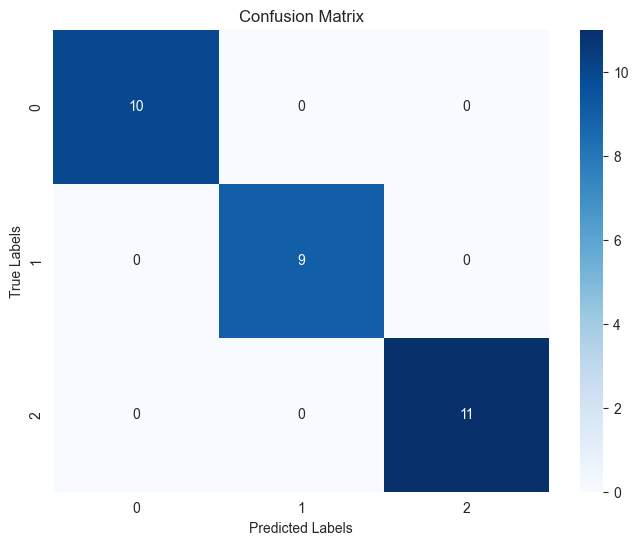

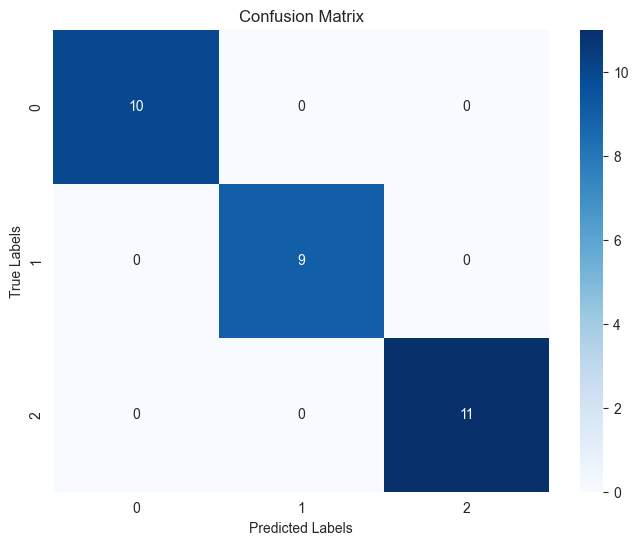

In [159]:
ml_model.plot_confusion_matrix(y_test, y_pred, labels=None, normalize=False, cmap="Blues")

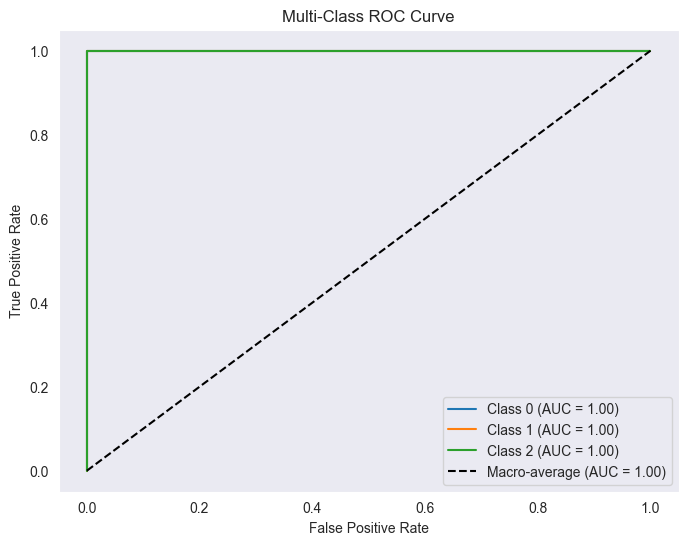

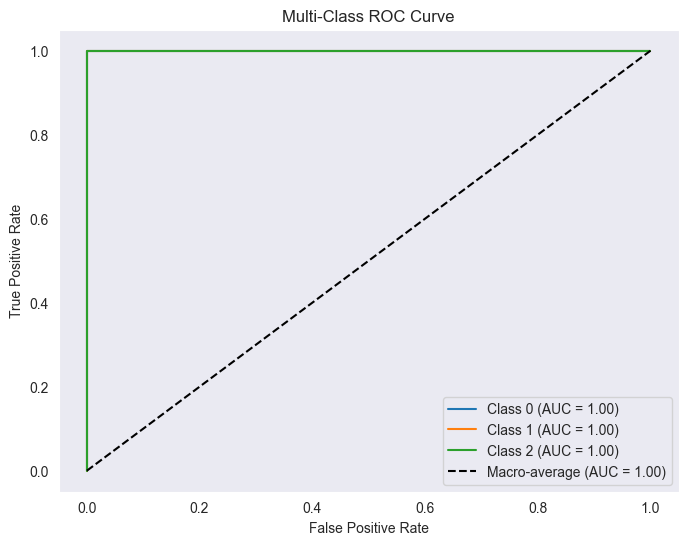

In [160]:
ml_model.plot_roc_auc(y_test, y_proba, labels=None, average="macro")

ValueError: Expected 2D array, got 1D array instead:
array=[3.1177057e-03 9.9022043e-01 4.5618208e-04 2.1723926e-03 3.0178740e-03
 9.9518317e-01 4.4825487e-03 2.6801559e-03 1.2896145e-03 2.0795120e-03
 2.7400681e-03 9.9578816e-01 9.9371380e-01 9.9613589e-01 9.9613589e-01
 9.4323605e-04 4.1698763e-04 2.4733930e-03 4.5828456e-03 2.7554453e-04
 9.9613589e-01 1.3408157e-03 9.9613589e-01 2.7554453e-04 1.0006587e-03
 4.6442266e-04 4.5619186e-04 1.0006587e-03 9.9578816e-01 9.9613589e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [164]:
from EasyML import Processor, DataSplitter , MLModel

In [165]:
Processor = Processor(filepath="../data/balanced_data.csv")